## Setup and Intro


In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 8.0)  # bigger plots by default. Adjust as desired
import numpy as np
import poppy
import gpipsfs

Populating the interactive namespace from numpy and matplotlib


This worksheet assumes you are already familiar with at least the basics of using the ipython notebook and python, and have at least glanced through the "GPI PSFs Intro" notebook. 

# Building up to the GPI Coronagraphic PSF

Let's begin by creating a GPI simulator object, and making a direct mode (non-coronagraphic) PSF. For now we will keep things simple and turn **off** the satellite spots and the bad-actuator masking tabs in this simulation.  We will turn **on** an option for displaying before and after the occulter and Lyot planes (instead of the default which is just to show after).  We will also decrease the number of pixels used for the pupil to (512,512) instead of the default (1024,1024) just to make things run a bit faster. 

In [8]:
gpi = gpipsfs.GPI(npix=512, satspots=False, lyot_tabs=False, display_before=True)

Now let's make a simple direct mode PSF at a single wavelength. Feel free to change around these options if you would like to experiment with another filter or wavelength. 

after Gemini South Primary,              total intensity = 1
after GPI Apodizer CLEAR,                total intensity = 1
after Before FPM,                        total intensity = 1
after GPI FPM SCIENCE,                   total intensity = 1
after Before Lyot,                       total intensity = 1
after GPI Lyot Open,                     total intensity = 1
before GPI lenslet array,                total intensity = 0.991


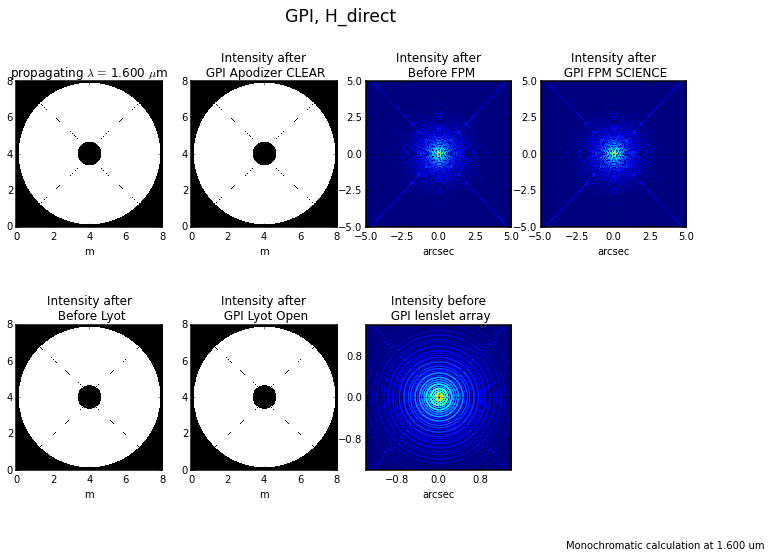

In [9]:
gpi.obsmode ='H_direct'
wavelen = 1.6e-6  # wavelength is always given in meters
psf_direct= gpi.calcPSF(monochromatic=wavelen, display=True, verbose=True)  

First step in blocking star light: let's add a circular coronagraph occulter, all by itself:

In [ ]:
gpi.occulter="H"
psf= gpi.calcPSF(monochromatic=1.6e-6, display=True, verbose=True)

Look at all that light in the Lyot plane: lots of residual at the edges, center, and secondary supports. Let's try to block that by adding a Lyot stop: 

In [ ]:
gpi.lyotmask="080m12_04"  # this happens to be the code name for the mask used in H. 
psf= gpi.calcPSF(monochromatic=1.6e-6, display=True, verbose=True)

That worked pretty well. We could probably block even more light by using a larger occulter. (but at a cost in lower throughput for off axis sources)

In [ ]:
gpi.lyotmask="080m12_10" 
psf= gpi.calcPSF(monochromatic=wavelen, display=True, verbose=True)

Let's try something different: an apodizer. First we will try this all by itself. 

In [ ]:
gpi.obsmode ='H_direct'  # resets to FPM=SCIENCE (none), Apodizer=CLEAR, Lyot=Open
gpi.apodizer="H" 
psf= gpi.calcPSF(monochromatic=wavelen, display=True, verbose=True)

The apodizer all by itself strongly attenuates most of the Airy rings. About half the starlight remains, but it's all concentrated pretty close to the middle. 

Now let's add the occulter back in:

In [ ]:
gpi.occulter='H'
psf= gpi.calcPSF(monochromatic=wavelen, display=True, verbose=True)

And the Lyot mask. Here at least we've re-assembled the H_coron mode. 

In [ ]:
gpi.lyotmask="080m12_04"  
psf= gpi.calcPSF(monochromatic=wavelen, display=True, verbose=True)

## Normalizing to Contrast Units

## Spots and Tabs

Let's turn back on the sat spots

after Gemini South Primary,              total intensity = 1
after GPI Apodizer H,                    total intensity = 0.45
after Before FPM,                        total intensity = 0.45
after GPI FPM H,                         total intensity = 0.00455
after Before Lyot,                       total intensity = 0.00455
after GPI Lyot 080m12_04,                total intensity = 0.00158
before GPI lenslet array,                total intensity = 0.000285


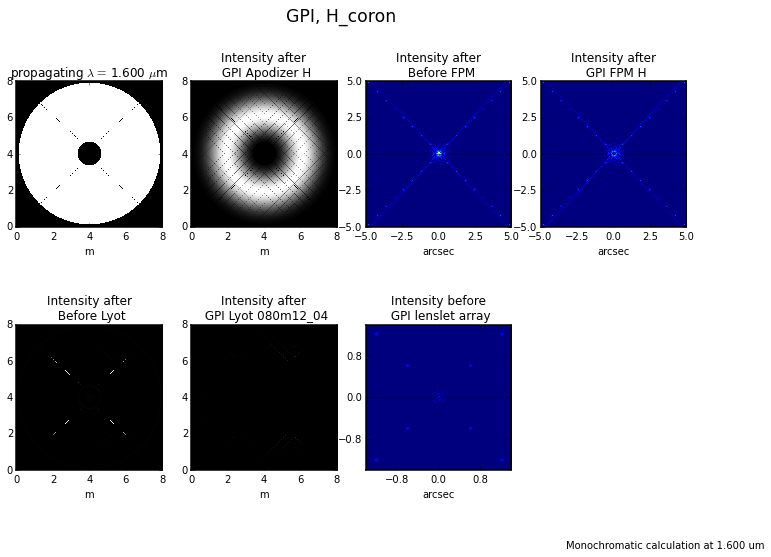

In [11]:
gpi.satspots=True
psf= gpi.calcPSF(monochromatic=wavelen, display=True, verbose=True)

Add in a bad actuator as a phase spot on the pupil

Compute the PSF and see there is still some light left

In [ ]:
Then turn on the sat spot tabs in the DM